# Vehicle Insurance Claim EDA
This is an exploratory analysis of vehicle insurance claim data. Each row in this dataset represents an individual insurace claim.
In this analysis, I will look for interesting patterns and insights in the data set. Ultimately, the goal is to predict whether a claim is fraud (FraudFound_P) or not based on other variables, but in this analysis, I will only be taking the beginning steps of data exploaration. Some questions that I would like to explore in this analysis are: 
* Who files vehicle insurance claims?
* When are these claims most likely to be filed?
<br /> The first step is to import the appropriate packages for this analysis.

In [1]:
import pandas as pd #
pd.plotting.register_matplotlib_converters()
import numpy as np  #linear algebra and transformations
import seaborn as sns  #visualization
import matplotlib.pyplot as plt #visualization
%matplotlib inline
 
    
#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Model Evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

Read in the data using pandas.

In [2]:
file_path = "../input/vehicle-claim-fraud-detection/fraud_oracle.csv"
ICD = pd.read_csv(file_path)

Get an idea of the size of the dataset. In this case it has 15420 rows and 33 columns.

In [3]:
ICD.shape

(15420, 33)

Take a look at the first 5 rows of the dataset. In this case, we can see that some columns are left out.

In [4]:
ICD.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


List the names of all columns and see what types they are.

In [5]:
ICD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

It is unlikely that I will use all of these columns to answer my questions, but it is good to have an idea of what information is available to use.
<br /> I will begin by answering the question of who files insurance claims, which may also answer who is likely to get into accidents.
For the numeric variables, we can get some quick summary statistics.

In [6]:
ICD.agg(
    {
        'Age': ["min", "max", "median", "mean"],
        'Deductible': ["min", "max", "median", "mean"],
        'DriverRating': ["min", "max", "median", "mean"],
    }
)


,Age,Deductible,DriverRating
min,0.000000,300.00000,1.000000
max,80.000000,700.00000,4.000000
median,38.000000,400.00000,2.000000
mean,39.855707,407.70428,2.487808


This table gives a good quick glance at the averages and range of these three variables. At first glance, seeing a recorded age of 0 seems like an error. I am going to check how many records have an age of 0.

In [7]:
(ICD["Age"] == 0).sum()

320

For predictive modeling, it would make sense to deal with these cases (maybe imputation). However, in this case we will remove them so they don't affect graphs.

In [8]:
ICD_filtered = ICD[ICD['Age'] != 0]

Text(0.5, 1.0, 'Age Distribution')

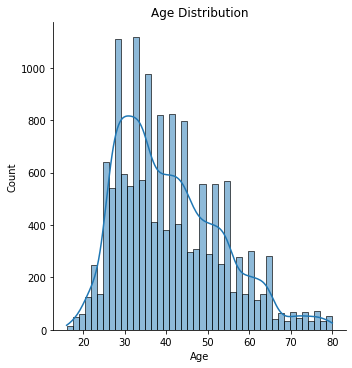

In [9]:
sns.displot(ICD_filtered['Age'], kde = True)
plt.title("Age Distribution")

The age distribution appears to be slightly skewed to the right.

Text(0.5, 1.0, 'Deductible Distribution')

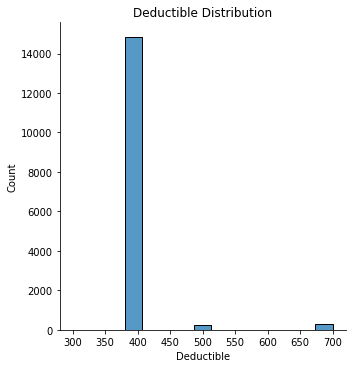

In [10]:
sns.displot(ICD['Deductible'], kde = False)
plt.title("Deductible Distribution")

Note: The vast majority of deductibles are 400 with more rare cases of 500 and 675.

Text(0.5, 1.0, 'DriverRating Distribution')

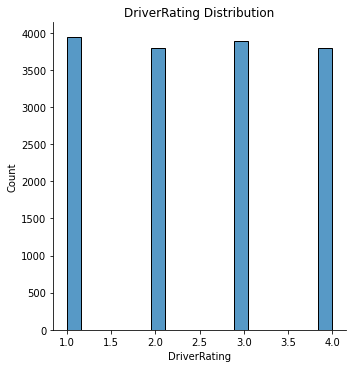

In [11]:
sns.displot(ICD['DriverRating'], kde = False)
plt.title("DriverRating Distribution")


It appears that driver ratings follow a fairly uniform distribution. This is interesting, as you would think that drivers with a higher rating would be in less accidents and file less claims, which is only the case by a close margin. Below are the exact counts for each rating.

In [12]:
ICD.groupby("DriverRating").DriverRating.count()

DriverRating
1    3944
2    3801
3    3884
4    3791
Name: DriverRating, dtype: int64

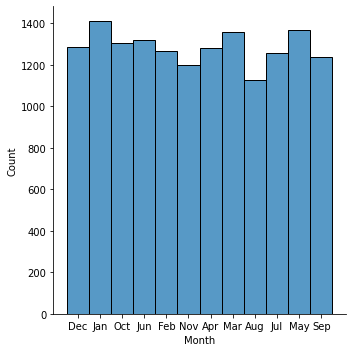

In [13]:
sns.displot(data = ICD['Month'])

The most accidents occur in January, May, and March, respectively. This distribution is almost uniform.

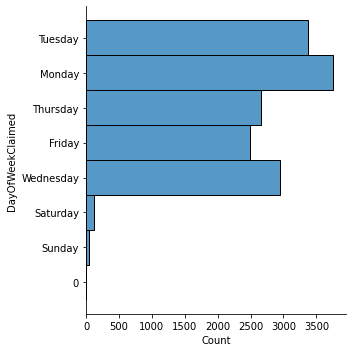

In [14]:
sns.displot(y = ICD['DayOfWeekClaimed'])

Most claims are made on Monday, followed by Tuesday.

<AxesSubplot:>

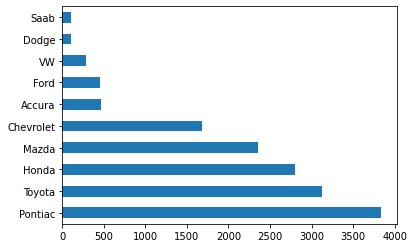

In [15]:
n = 10
ICD["Make"].value_counts()[:n].plot(kind = 'barh')

The above list shows the 10 most common car makes that are listed on a claim. There appears to be 5 main makes that are in significantly more accidents than other makes. It may be possible to classify these as high risk makes. However, since these makes are very common they may just be more likely to be involved in accidents. 

In [16]:
ICD.AgeOfVehicle.unique()

array(['3 years', '6 years', '7 years', 'more than 7', '5 years', 'new',
       '4 years', '2 years'], dtype=object)

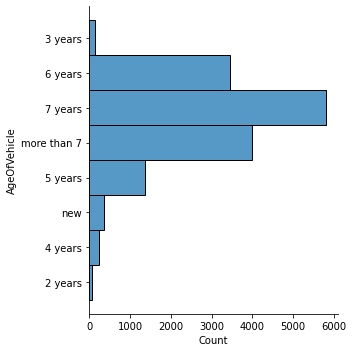

In [17]:
sns.displot(y = ICD["AgeOfVehicle"])

Here we see that most vehicles are 6 years or older.

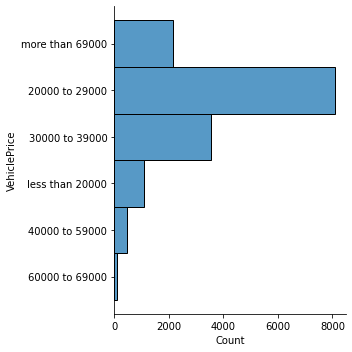

In [18]:
sns.displot(y = ICD["VehiclePrice"])

In [19]:
ICD['FraudFound_P'].mean()

0.05985732814526589

In [20]:
1-ICD['FraudFound_P'].mean()

0.9401426718547341

This means that a model that predicts all claims as not fraudulent will be correct about 94% of the time. We want to improve on this by considering which factors can help predict fraudulent claims. 

In this dataset, about 6% of rows are classified as fraudulent claims.

In [21]:
ICD['FraudFound_P'] = pd.Categorical(ICD.FraudFound_P)

<AxesSubplot:xlabel='DriverRating', ylabel='Age'>

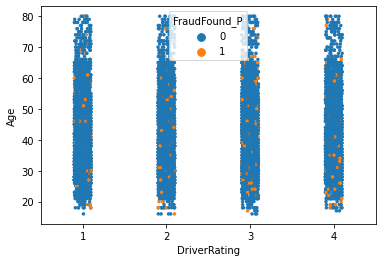

In [22]:
sns.stripplot(x='DriverRating', y= 'Age', hue = 'FraudFound_P', data = ICD_filtered, size = 3.5)

This plot shows that fraud usually appears to be spread throughout all ages and driver ratings. There are some areas where younger ages may have clusters of fraudulent claims. 

### Dimesionality Reduction

We want to reduce the amount of features we use. First, we will see which attributes share a relationship with the target using mutual information.

In [23]:
X = ICD_filtered.copy()
y = X.pop("FraudFound_P")


# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes
discrete_features = X.dtypes == int

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15100 entries, 0 to 15419
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Month                 15100 non-null  int64
 1   WeekOfMonth           15100 non-null  int64
 2   DayOfWeek             15100 non-null  int64
 3   Make                  15100 non-null  int64
 4   AccidentArea          15100 non-null  int64
 5   DayOfWeekClaimed      15100 non-null  int64
 6   MonthClaimed          15100 non-null  int64
 7   WeekOfMonthClaimed    15100 non-null  int64
 8   Sex                   15100 non-null  int64
 9   MaritalStatus         15100 non-null  int64
 10  Age                   15100 non-null  int64
 11  Fault                 15100 non-null  int64
 12  PolicyType            15100 non-null  int64
 13  VehicleCategory       15100 non-null  int64
 14  VehiclePrice          15100 non-null  int64
 15  PolicyNumber          15100 non-null  int64
 16  RepN

In [25]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[1:12]  # show a few features with their MI scores

PolicyType             0.017125
BasePolicy             0.016314
Fault                  0.011655
VehicleCategory        0.010871
Age                    0.003415
AddressChange_Claim    0.002028
VehiclePrice           0.001839
Make                   0.001724
Deductible             0.001662
PastNumberOfClaims     0.001612
MonthClaimed           0.001347
Name: MI Scores, dtype: float64

These scores are all quite low, which shows a weak relationship between these variables and the target. 

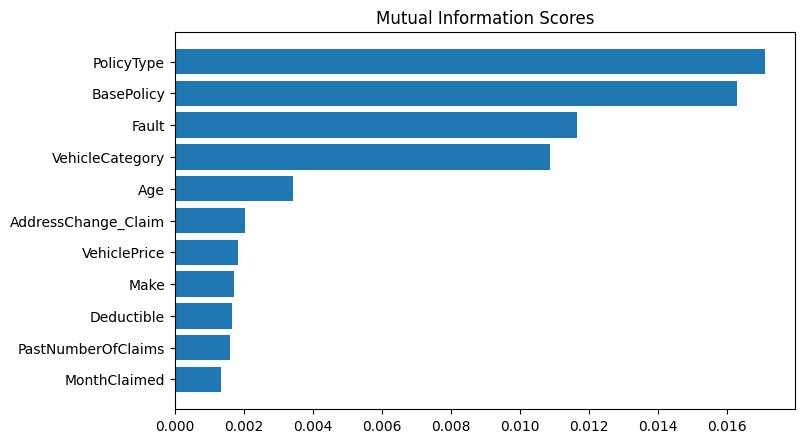

In [26]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[1:12])

In [27]:
ICD['PolicyType'].unique()

array(['Sport - Liability', 'Sport - Collision', 'Sedan - Liability',
       'Utility - All Perils', 'Sedan - All Perils', 'Sedan - Collision',
       'Utility - Collision', 'Utility - Liability', 'Sport - All Perils'],
      dtype=object)

In [28]:
ICD['BasePolicy'].unique()

array(['Liability', 'Collision', 'All Perils'], dtype=object)

In [29]:
x_features = list(mi_scores[1:12].index)
x_fac = X[x_features]

Next, we will use a correlation matrix to see correlations between the independent variables 

<AxesSubplot:>

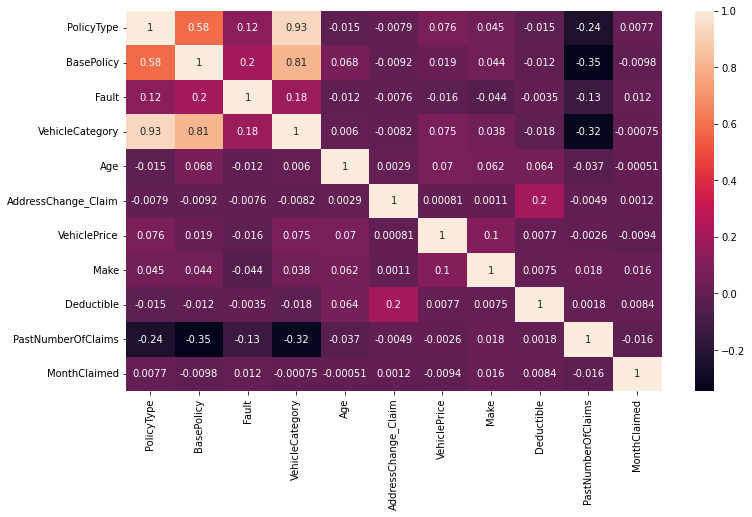

In [30]:
plt.figure(figsize=(12,7))
sns.heatmap(x_fac.corr(), annot=True)

## Data Preprocessing Pipeline

Some different steps will be taken to ensure that the data we are using is suitable for the models that will be used. This includes imputation for missing values and other steps. 

Before we do any of these steps, we want to ensure that we split the data into train and test sections to gauge how well our model can generalize on unseen data.

In [31]:
df_temp = ICD.copy()

#We have to deal with the 0 values in the Age column
df_temp["Age"] = df_temp["Age"].replace(0,ICD["Age"].median())


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)




In [32]:
#turn all object columns into categorical columns
for labels, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[labels] = content.astype("category").cat.as_ordered()
        
#now turn from categorical to numeric
for labels, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_temp[labels] = pd.Categorical(content).codes

In [33]:
df_temp.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,2,5,6,6,1,6,5,1,0,2,...,1,3,0,0,0,3,0,2,1994,2
1,4,3,6,6,1,2,5,4,1,2,...,4,4,1,0,0,3,3,0,1994,1
2,10,5,0,6,1,5,10,2,1,1,...,5,6,0,0,0,3,3,0,1994,1
3,6,2,2,17,0,1,6,1,1,1,...,6,7,1,0,0,2,3,0,1994,2
4,4,5,1,6,1,6,4,2,0,2,...,3,4,0,0,0,3,3,0,1994,1


This dataset is ready for the algorithms that we will use. 

In [34]:
from sklearn.model_selection import train_test_split

y = df_temp.FraudFound_P
X = df_temp.drop(['FraudFound_P'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We will now check the distribution of the train and test groups for the target (0 or 1).

In [35]:
from collections import Counter

print(f"Training target statistics: {Counter(y_train)}")

print(f"Testing target statistics: {Counter(y_test)}")

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Training target statistics: Counter({0: 9715, 1: 616})
Testing target statistics: Counter({0: 4782, 1: 307})


((10331, 32), (5089, 32), (10331,), (5089,))

The data appears to be very unbalanced, so we will balance the weight of the classes.

In [36]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y = y_train)))
print(class_weights)

{0: 0.5317035512094699, 1: 8.385551948051948}


In [37]:
models = {"Logistic Regression": LogisticRegression(class_weight=class_weights,solver = 'liblinear'),
          "KNN": KNeighborsClassifier(),
          "Random Forest Classifier": RandomForestClassifier(class_weight=class_weights)}

In [38]:
def score_models(models, X_train, X_test, y_train, y_test):
    np.random.seed(1)
    
    model_score = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_score[name] = model.score(X_test, y_test)
    return model_score

In [39]:
model_score = score_models(models, X_train, X_test, y_train, y_test)
model_score

{'Logistic Regression': 0.6217331499312242,
 'KNN': 0.9355472587934761,
 'Random Forest Classifier': 0.9396738062487718}

These models performed at or worse than the level of making all negative predictions. Maybe we can tune one of the models to get better predictions.

In [40]:
#in this cell we will tune the n_neighbors parameter in the knn model
train_score = []
test_score = []

neighbors = range(1,15)
knn = KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors = i)
    knn.fit(X_train, y_train)
    
    # Update the training score list
    train_score.append(knn.score(X_train, y_train))
    
    # Update the test score list
    test_score.append(knn.score(X_test, y_test))

Maximum KNN score on Test data: 93.97


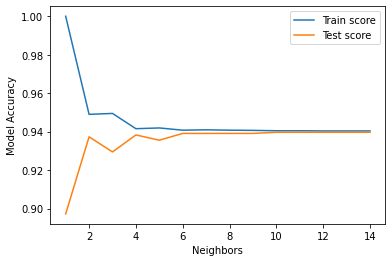

In [41]:
# Let's Plot And Viusalize The KNN Tunned Model
plt.plot(neighbors, train_score, label= "Train score")
plt.plot(neighbors, test_score, label= "Test score")
plt.xlabel("Neighbors")
plt.ylabel("Model Accuracy")
plt.legend()

print("Maximum KNN score on Test data: {:.2f}".format(max(test_score)*100))

This is not an improvement on the best model, which is the RFC, so we will focus on tuning the parameters for that model instead.

In [42]:
#hyperparameterGrid for RandomForestClassifier
rf_random_grid = {"n_estimators": np.arange(10,1000,50),
                  "max_depth": [None, 3, 5, 10],
                  "min_samples_split": np.arange(2, 20, 2),
                  "min_samples_leaf": np.arange(1, 20, 2)} 

# Setup random hyperparameter search for RandomForestClassifer
rf_rs = RandomizedSearchCV(RandomForestClassifier(class_weight=class_weights),
                           param_distributions=rf_random_grid,
                           cv=5,
                           verbose=True,
                           n_iter=10)

# Fitting random hyperparamter search
rf_rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.3min finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight={0: 0.5317035512094699,
                                                                  1: 8.385551948051948}),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [43]:
#this will return the best parameters for the rfc
rf_rs.best_params_

{'n_estimators': 160,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_depth': None}

In [44]:
rf_rs.score(X_test, y_test)

0.9390842994694439

This does not improve the model much above the default parameters. 

## Evaluating the tuned Random Forest Model

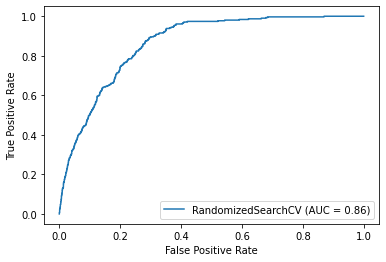

In [45]:
# Let's plot ROC Curve and calculate the AUC metric
plot_roc_curve(rf_rs, X_test,y_test)

In [46]:
y_preds = rf_rs.predict(X_test)

In [47]:
print(confusion_matrix(y_test,y_preds))

[[4764   18]
 [ 292   15]]


In [48]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4782
           1       0.45      0.05      0.09       307

    accuracy                           0.94      5089
   macro avg       0.70      0.52      0.53      5089
weighted avg       0.91      0.94      0.92      5089



To get another measure of our model's performance, we will find the cross validation scores. 

In [49]:
import warnings
warnings.filterwarnings("ignore")
# Cross-validated Precision
cv_precision = cross_val_score(rf_rs,
                         X,
                         y,
                         cv = 10,
                         scoring="precision")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.9min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.5min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.9min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.7min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.8min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.4min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.6min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.5min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.9min finished


In [50]:
cv_precision = np.mean(cv_precision)
print("The Precision for our Random Forest Classifier is: {:.2f}".format(cv_precision))

The Precision for our Random Forest Classifier is: 0.25


The interpretation of the precision metric is: If given a fraudulent claim, the model will give a correct prediction 25% of the time.

## Improvements:

To improve the performance on this dataset, we can look to minimize the number of attributes that we use in the model. This dimensionality reduction can help the model focus on more important features to make predictions with. We can also create new features from the existing features to help our models gain additional insight.

In addition, we can use more complex models such as XGBoost and Neural Networks, which may be better at finding patteres in this dataset. 